# Predicting Memorability using features like HMP, LBP, Aesthetics and C3D





Import all the necessary packages

In [ ]:
import pandas as pd
import pickle
import numpy as np
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt
from numpy import arange
from pandas import read_csv
from google.colab import drive
import os
from math import sqrt

from tensorflow.python.keras import Sequential
from tensorflow.python.keras import layers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

In [ ]:
# for reproducability
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

Get_score() - This function returns Spearman score

In [ ]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearman's correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

X_seq() - This function returns an array of features extracted from the input, which is dataframe.

In [ ]:
def define_x_seq(df ,max_len, column_name, array_size):
  X_seq = np.zeros((len(df[column_name]),max_len))
  for i in range(len(df[column_name])):
      n = array_size
      if n==0:
          print(i)
      else:
          X_seq[i,-n:] = df.loc[i,column_name]
  X_seq.shape
  return X_seq


Split_data() - This function split feaures into training and testing dataset in the ratio of 80 : 20 respectively

In [ ]:
def Split_data(X_seq):  
  Y = labels[['short-term_memorability','long-term_memorability']].values # targets
  X = X_seq # sequences
  X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42) # random state for reproducability
  return X_train, X_test, Y_train, Y_test

Loading the data from Google Drive.

In [ ]:
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/CA684_Assignment')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Install pyprind and tqdm to show progress bar whenever required

In [ ]:
!pip install pyprind
import pyprind

Load the ground truth values


In [ ]:
label_path = './Dev-set/Ground-truth/'
labels=pd.read_csv(label_path+'ground-truth.csv')

# 1> Best Performing Models - trained on training set (4800 dataset) and evaluated on validation set (1200 dataset)

## 1.1 Long-term Memorability

### 1.1.1 Loading Data - Aesthetic Features

read_aesthetic_features() - reads aesthetic feature files from Google drive

In [ ]:
os.chdir('/content/drive/My Drive/CA684 - Machine Learning Assignment/dev-set_aesthetic-features/features/aesthetic_visual_features')

# Read Aesthetic mean and median feature files
def read_aesthetic_features(fname):
    """Scan vectors from file""" 
    if os.path.exists(fname):
      with open(fname) as f:
          for line in f:
              aes =[float(item) for item in line.split(',')] # convert to float type, using default separator
      return aes
    else:
      return np.zeros(109)

Read aesthetic files one by one and store them in a dataframe

In [ ]:
df_aes = pd.DataFrame(columns=['video','AES-mean','AES-median'])

pbar = pyprind.ProgBar(len(labels['video']), title='Loading Aesthetic files')

# load the Aesthetic files
for i, video in enumerate(labels['video']):
    df_aes.loc[i,'video'] = video   
    df_aes.loc[i,'AES-mean'] = read_aesthetic_features('./aesthetic_feat_dev-set_mean/' + (video.split('.')[0]) + '.txt')
    df_aes.loc[i,'AES-median'] = read_aesthetic_features('./aesthetic_feat_dev-set_median/' + (video.split('.')[0]) + '.txt')
    pbar.update()

Save df_aes as a pickle file for later use.

In [ ]:
os.chdir('/content/drive/My Drive/')
df_aes.to_pickle("AES_file.pkl")

Read AES_file.pkl and store it in a dataframe

In [ ]:
os.chdir('/content/drive/My Drive/CA684 - Machine Learning Assignment')
df_aes = pd.read_pickle("AES_file.pkl")
print(df_aes)

               video  ...                                         AES-median
0        video3.webm  ...  [0.180874, 0.715626, 0.19893, 0.610453, 0.1216...
1        video4.webm  ...  [0.146076, 0.55007, 0.460729, 0.424397, 0.3418...
2        video6.webm  ...  [0.063898, 0.827439, 0.211925, 0.720297, 0.129...
3        video8.webm  ...  [0.380539, 0.134683, 0.746891, 0.171604, 0.697...
4       video10.webm  ...  [0.427258, 0.381448, 0.582746, 0.409475, 0.489...
...              ...  ...                                                ...
5995  video7488.webm  ...  [0.413464, 0.195451, 0.71372, 0.282848, 0.6534...
5996  video7489.webm  ...  [0.264377, 0.192016, 0.448979, 0.164919, 0.412...
5997  video7491.webm  ...  [0.177078, 0.221348, 0.67387, 0.180848, 0.6131...
5998  video7492.webm  ...  [0.113838, 0.585274, 0.496719, 0.474999, 0.352...
5999  video7493.webm  ...  [0.554715, 0.132732, 0.691821, 0.209476, 0.646...

[6000 rows x 3 columns]


Store all the values in column 'AES-mean' in a numpy array

In [ ]:
max_len = 109
X_seq = define_x_seq(df_aes,max_len,'AES-mean', len(df_aes.loc[0,'AES-mean']))
X_seq.shape

(6000, 109)

Split the dataset in 80: 20 ratio for training and testing sets

In [ ]:
X_train, X_test, Y_train, Y_test = Split_data(X_seq)

### 1.1.2 Random Forest - Best Long-term memorability score (0.134)

Train Aesthetic features on a Random Forest

In [ ]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Get Spearman's scores

In [ ]:
predictions = rf.predict(X_test)
Get_score(predictions, Y_test)

The Spearman's correlation coefficient is: 0.324
The Spearman's correlation coefficient is: 0.134


## 1.2 Short-term Memorability

### 1.2.1 Loading Data - LBP and C3D

Load LBP from the pickle file generate in section 4.1 
https://colab.research.google.com/drive/19NdaFjBPQlESBok79bLd0f9-lYwpW1ht?authuser=2#scrollTo=tsoQsto1h6Ou&line=1&uniqifier=1

In [ ]:
os.chdir('/content/drive/My Drive/CA684 - Machine Learning Assignment')
df_lbp = pd.read_pickle("LBP_file.pkl")
print(df_lbp)

               video  ...                                            LBP-112
0        video3.webm  ...  [0.01043451, 0.00247637, 0.00192178, 0.0014665...
1        video4.webm  ...  [0.00991127, 0.00292679, 0.00233845, 0.0020862...
2        video6.webm  ...  [0.00782986, 0.00120563, 0.00085166, 0.0006939...
3        video8.webm  ...  [0.01097222, 0.00419367, 0.0028178, 0.00211709...
4       video10.webm  ...  [0.02204427, 0.00510851, 0.00511767, 0.0041420...
...              ...  ...                                                ...
5995  video7488.webm  ...  [0.01651235, 0.0036738, 0.00279562, 0.00200762...
5996  video7489.webm  ...  [0.03702064, 0.00227286, 0.00241802, 0.0025082...
5997  video7491.webm  ...  [0.02289207, 0.00598573, 0.00546055, 0.0042144...
5998  video7492.webm  ...  [0.01113329, 0.00202691, 0.00201678, 0.0017365...
5999  video7493.webm  ...  [0.01129292, 0.00211179, 0.0017853, 0.00150222...

[6000 rows x 4 columns]


Loading C3D from pickle file generated in section 3.1 https://colab.research.google.com/drive/19NdaFjBPQlESBok79bLd0f9-lYwpW1ht?authuser=2#scrollTo=vBK1ypdq-U8B&line=1&uniqifier=1

In [ ]:
os.chdir('/content/drive/My Drive/CA684 - Machine Learning Assignment')
pickle_df_c3d = pd.read_pickle("C3D_file.pkl")
print(pickle_df_c3d)

               video                                                C3D
0        video3.webm  [0.02024942, 0.0015778, 0.00082625, 0.00094509...
1        video4.webm  [0.000118, 0.00089075, 0.00018769, 4.543e-05, ...
2        video6.webm  [0.01176522, 0.00074577, 0.00078353, 1.328e-05...
3        video8.webm  [0.00022343, 0.00016499, 7.35e-06, 1.615e-05, ...
4       video10.webm  [9.006e-05, 0.00061494, 0.00343634, 0.00128092...
...              ...                                                ...
5995  video7488.webm  [0.35724622, 0.07598178, 0.00302532, 2.772e-05...
5996  video7489.webm  [0.19280288, 0.00093812, 0.00506054, 1.35e-06,...
5997  video7491.webm  [2.589e-05, 0.00012192, 2.781e-05, 2.608e-05, ...
5998  video7492.webm  [0.26509121, 0.09653918, 5.971e-05, 0.00022735...
5999  video7493.webm  [0.02058949, 0.00122141, 0.00206607, 0.0023161...

[6000 rows x 2 columns]


Concatenate C3D and LBP together

In [ ]:
max_len = 467
len(pickle_df_c3d)
X_seq = np.zeros((len(df_lbp['LBP-112']),max_len))
count = 0
for i in range(len(df_lbp['LBP-112'])):
    n = 467
    if n==0:
        print(i)
    elif len(df_lbp.loc[i,'LBP-112'] + df_lbp.loc[i,'LBP-56'] + df_lbp.loc[i,'LBP-0']) == 366:
        X_seq[i,-n:] = df_lbp.loc[i,'LBP-112'] + df_lbp.loc[i,'LBP-56'] + df_lbp.loc[i,'LBP-0'] + pickle_df_c3d.loc[i,'C3D']
    else:
      count = count + 1
print(count)
X_seq.shape

15


(6000, 467)

Split the data in training and testing set

In [ ]:
X_train, X_test, Y_train, Y_test =Split_data(X_seq)

### 1.2.2 Random Forest - Best short-term memorability score (0.337)

In [ ]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, Y_train)
predictions = rf.predict(X_test)
Get_score(predictions, Y_test)

The Spearman's correlation coefficient is: 0.337
The Spearman's correlation coefficient is: 0.132


# 2> Predicting video memorability using HMP

## 2.1 Loading HMP

read_HMP() - reads HMP values from the google drive and loads them in a numpy array

In [ ]:
# load HMP
def read_HMP(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

Call read_HMP() function and store the HMP values in a dataframe

In [ ]:
df_hmp = pd.DataFrame(columns=['video','HMP'])

# load the HMP
for i, video in enumerate(labels['video']):
    File_name = (video.split('.')[0]) + '.txt'
    hmp_path = './Dev-set/HMP/' + File_name
    df_hmp.loc[i,'video'] = video
    df_hmp.loc[i,'HMP'] = read_HMP(hmp_path)

Store HMP values in a pickle file for later use.

In [ ]:
os.chdir('/content/drive/My Drive/')
!pwd
df_hmp.to_pickle("HMP_file.pkl")

/content/drive/My Drive


Read HMP_file.pkl from the Google drive and store them in pickl_df_hmp

In [ ]:
os.chdir('/content/drive/My Drive/CA684 - Machine Learning Assignment')
pickl_df_hmp = pd.read_pickle("HMP_file.pkl")
print(pickl_df_hmp)

               video                                                HMP
0        video3.webm  [0.125563, 0.024036, 0.000314, 0.0, 0.015864, ...
1        video4.webm  [0.007526, 0.001421, 6.8e-05, 0.0, 0.001184, 0...
2        video6.webm  [0.109584, 0.018978, 0.000289, 0.0, 0.008774, ...
3        video8.webm  [0.120431, 0.013561, 0.000277, 0.0, 0.018974, ...
4       video10.webm  [0.005026, 0.001356, 5.5e-05, 0.0, 0.000665, 2...
...              ...                                                ...
5995  video7488.webm  [0.003779, 0.001352, 7.7e-05, 0.0, 0.000475, 7...
5996  video7489.webm  [0.001396, 0.000417, 7e-06, 0.0, 0.000145, 4e-...
5997  video7491.webm  [0.023139, 0.007435, 0.000322, 0.0, 0.004319, ...
5998  video7492.webm  [0.0149, 0.004607, 9.9e-05, 0.0, 0.001559, 1.4...
5999  video7493.webm  [0.041592, 0.013047, 0.000448, 0.0, 0.010044, ...

[6000 rows x 2 columns]


In [ ]:
print(labels)

               video  ...  nb_long-term_annotations
0        video3.webm  ...                        13
1        video4.webm  ...                        12
2        video6.webm  ...                        10
3        video8.webm  ...                        11
4       video10.webm  ...                        10
...              ...  ...                       ...
5995  video7488.webm  ...                         9
5996  video7489.webm  ...                        31
5997  video7491.webm  ...                        11
5998  video7492.webm  ...                        16
5999  video7493.webm  ...                        13

[6000 rows x 5 columns]


In [ ]:
len(pickl_df_hmp.loc[1]['HMP'])

6075

Define the maximum length of feature

In [ ]:
# calculating max length
max_len = 6075

Making sequences index same length by calling X_seq function

In [ ]:
X_seq = define_x_seq(pickl_df_hmp,max_len,'HMP', len(pickl_df_hmp.loc[0,'HMP']))

In [ ]:
print(X_seq[5999,:])

[0.041592 0.013047 0.000448 ... 0.000289 0.000988 0.000161]


In [ ]:
print(X_seq[0,:]) # length of 1st sequence after padding the caption with zeros.

[1.25563e-01 2.40360e-02 3.14000e-04 ... 8.60000e-05 5.80000e-04
 0.00000e+00]


## 2.2 Building network model - using Keras library (-0.052, 0.013)


Split data set to training and test data

In [ ]:
X_train, X_test, Y_train, Y_test = Split_data(X_seq)

Shape of the data

In [ ]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4800, 6075)
X_test (1200, 6075)
Y_train (4800, 2)
Y_test (1200, 2)


### 2.2.1 Construction

A dense layer is just a regular layer of neurons in a NN. Each neuron recieves input from all the neurons in the previous layer, thus densely connected. 

The layer has a weight matrix W, a bias vector b, and the activations of previous layer a. The following is the docstring of class Dense from the keras documentation:

*output = activation(dot(input, kernel) + bias)*

where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer

In [ ]:
# add dropout - Helps prevent overfitting
# add regularizers - Regularizers allow to apply penalties on layer parameters or layer activity during optimization.
# activations - Used to determine the output of network. It maps the resulting values in between 0 to 1 or -1 to 1 etc. (depending upon the function).

model = Sequential() # The Sequential model is a linear stack of layers.

# You can simply add layers via the .add() method:
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005),input_shape=(max_len,))) # Just your regular densely-connected NN layer.
model.add(layers.Dropout(0.5)) #Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training; helps prevent overfitting.
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2,activation='sigmoid'))

### 2.2.2 Compilation
Define three arguments:

1.   An optimizer
2.   A loss function
3.   A list of metrics


In [ ]:
# compile the model 
model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

### 2.2.3 Training

Train the model using our training and testing data.

In [ ]:
# training the model 
history = model.fit(X_train,Y_train,epochs=20)

Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 0.1009 - accuracy: 0.5460
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.0500 - accuracy: 0.6006
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.6874
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.0242 - accuracy: 0.6810
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 0.6876
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.0175 - accuracy: 0.6822
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.6942
Epoch 8/20
150/150 [==============================] - 0s 3ms/step - loss: 0.0155 - accuracy: 0.7030
Epoch 9/20
150/150 [==============================] - 0s 2ms/step - loss: 0.0154 - accuracy: 0.6987
Epoch 10/20
150/150 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.7031

### 2.2.4 Visualising the validation and training loss

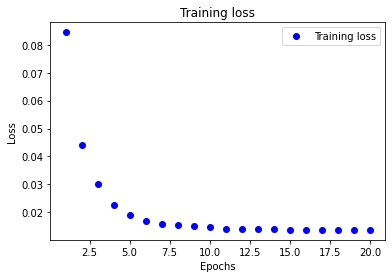

In [ ]:
loss = history.history['loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Training and validation accuracy

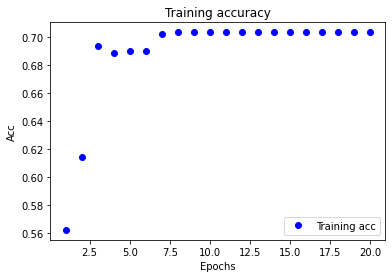

In [ ]:
plt.figure()
acc = history.history['accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

Predictions on the newly trained model....

In [ ]:
predictions = model.predict(X_test)
Get_score(predictions, Y_test) # Try remember what the Spearman scores actually mean!

The Spearman's correlation coefficient is: -0.052
The Spearman's correlation coefficient is: 0.013


Saving your model

In [ ]:
model.save('/My Drive/CA684 - Machine Learning Assignment/HMP_Model.h5')  # creates a HDF5 file 'my_model.h5'

## 2.3 PCA to reduce dimension

In [ ]:
# Generate column names
columns = []
for i in range(len(pickl_df_hmp.loc[0,'HMP'])):
  columns.append(i)

In [ ]:
PCA_HMP = pd.DataFrame(pickl_df_hmp['HMP'].to_list(), columns = columns)

In [ ]:
PCA_HMP.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,6035,6036,6037,6038,6039,6040,6041,6042,6043,6044,6045,6046,6047,6048,6049,6050,6051,6052,6053,6054,6055,6056,6057,6058,6059,6060,6061,6062,6063,6064,6065,6066,6067,6068,6069,6070,6071,6072,6073,6074
0,0.125563,0.024036,0.000314,0.0,0.015864,0.000358,0.0,0.000000,0.000086,0.0,0.0,0.0,0.0,0.002795,0.000054,0.0,0.000000,0.000037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000002,0.000173,0.000459,0.000000,0.000148,0.000104,0.000000,0.000121,0.000551,0.000000,0.000114,0.000884,0.000002,0.000116,0.000077,0.000002,0.000027,0.000136,0.000000,0.000000,0.000002,0.000000,0.000091,0.000035,0.000000,0.000163,0.000467,0.000002,0.000010,0.000017,0.000000,0.000393,0.000279,0.000000,0.000289,0.001926,0.000000,0.000086,0.000580,0.000000
1,0.007526,0.001421,0.000068,0.0,0.001184,0.000143,0.0,0.000000,0.000079,0.0,0.0,0.0,0.0,0.000246,0.000024,0.0,0.000000,0.000042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000685,0.000308,0.001054,0.000751,0.000176,0.000062,0.000000,0.000123,0.000398,0.000086,0.000246,0.000433,0.000446,0.000143,0.000053,0.000000,0.000053,0.000099,0.000009,0.000004,0.000033,0.000004,0.000051,0.000035,0.000000,0.000062,0.000358,0.000035,0.000024,0.000083,0.000053,0.000244,0.000066,0.000000,0.000081,0.000617,0.000094,0.000220,0.000762,0.001224
2,0.109584,0.018978,0.000289,0.0,0.008774,0.000208,0.0,0.000002,0.000088,0.0,0.0,0.0,0.0,0.002046,0.000061,0.0,0.000000,0.000038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000083,0.000057,0.000158,0.000073,0.000021,0.000009,0.000002,0.000019,0.000095,0.000021,0.000019,0.000090,0.000073,0.000050,0.000024,0.000000,0.000012,0.000021,0.000000,0.000000,0.000002,0.000000,0.000017,0.000007,0.000002,0.000066,0.000203,0.000026,0.000002,0.000040,0.000007,0.000054,0.000045,0.000000,0.000028,0.000291,0.000033,0.000052,0.000258,0.000215
3,0.120431,0.013561,0.000277,0.0,0.018974,0.000913,0.0,0.000024,0.000713,0.0,0.0,0.0,0.0,0.002496,0.000149,0.0,0.000011,0.000157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000210,0.000434,0.000543,0.000412,0.000412,0.000045,0.000003,0.000144,0.000282,0.000037,0.000197,0.000218,0.000157,0.000237,0.000021,0.000000,0.000040,0.000056,0.000008,0.000005,0.000013,0.000019,0.000168,0.000013,0.000000,0.000133,0.000202,0.000029,0.000029,0.000035,0.000059,0.001110,0.000075,0.000008,0.000333,0.000793,0.000101,0.000588,0.000503,0.000452
4,0.005026,0.001356,0.000055,0.0,0.000665,0.000029,0.0,0.000000,0.000024,0.0,0.0,0.0,0.0,0.000147,0.000020,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000160,0.000996,0.001604,0.000103,0.000768,0.000215,0.000009,0.000415,0.000926,0.000020,0.000538,0.001178,0.000050,0.000518,0.000169,0.000007,0.000134,0.000169,0.000007,0.000026,0.000046,0.000007,0.000373,0.000088,0.000000,0.000338,0.000441,0.000029,0.000070,0.000149,0.000009,0.000882,0.000200,0.000009,0.000559,0.001097,0.000018,0.000632,0.001128,0.000064


In [ ]:
# Generate column names
PCA_columns = []
for i in range(100):
  PCA_columns.append('PCA'+str(i))
len(PCA_columns)

100

In [ ]:
pca = PCA(n_components=100)
principalComponents = pca.fit_transform(PCA_HMP)
principalDf = pd.DataFrame(data = principalComponents
             , columns = PCA_columns)
principalDf.head()

,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,PCA16,PCA17,PCA18,PCA19,PCA20,PCA21,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29,PCA30,PCA31,PCA32,PCA33,PCA34,PCA35,PCA36,PCA37,PCA38,PCA39,...,PCA60,PCA61,PCA62,PCA63,PCA64,PCA65,PCA66,PCA67,PCA68,PCA69,PCA70,PCA71,PCA72,PCA73,PCA74,PCA75,PCA76,PCA77,PCA78,PCA79,PCA80,PCA81,PCA82,PCA83,PCA84,PCA85,PCA86,PCA87,PCA88,PCA89,PCA90,PCA91,PCA92,PCA93,PCA94,PCA95,PCA96,PCA97,PCA98,PCA99
0,0.102093,-0.022775,-0.012566,-0.007334,0.005708,-0.018789,-0.010647,-0.007567,-0.000473,-0.004699,0.005531,0.001799,0.003617,0.005426,-0.000819,0.001739,0.003488,-0.003767,-0.000426,-0.003877,0.001663,-0.003303,-0.001731,-0.001289,0.002878,0.002616,-0.000529,-0.002209,0.003940,0.000231,0.000560,0.001313,-0.004649,0.000695,-0.000826,0.001018,0.000146,0.002140,0.000679,-0.000389,...,0.000686,-0.001101,0.000956,0.000006,0.000636,-0.000757,-0.000709,0.000474,0.001631,-0.001092,-0.000019,-0.000768,0.001675,-0.000491,-0.001406,-0.000301,0.001170,-0.000693,0.000358,-0.000248,0.000824,0.001156,0.000402,0.000302,0.000277,-0.000009,0.001263,-0.000399,0.000162,-0.000914,0.000664,0.000948,-0.000094,-0.000372,0.000333,-0.000205,0.000074,-0.000604,-0.000542,-0.000070
1,-0.027480,0.014782,-0.007706,0.004680,-0.018600,0.005358,-0.018797,-0.010442,0.015245,0.009886,0.003516,-0.000194,0.002001,-0.002598,-0.003027,0.005247,0.000675,-0.003136,0.003093,0.001711,-0.005403,0.002060,0.001747,0.000776,0.000742,0.001425,0.000882,-0.000961,0.000328,-0.002514,-0.000230,-0.000283,0.001731,-0.000941,-0.003579,-0.000543,-0.003754,0.001298,0.002444,-0.002914,...,-0.000028,0.000133,-0.000056,0.000571,0.000484,0.000111,-0.000657,0.000697,-0.000809,0.000918,0.000584,0.000374,0.000753,-0.000641,0.000597,0.000500,0.000612,-0.000516,-0.000896,-0.000473,-0.000480,0.000880,0.000028,-0.000050,-0.000154,0.000063,-0.000723,-0.000237,0.001015,-0.000348,0.000590,0.000145,0.000008,-0.000098,0.000243,-0.000421,0.000326,0.000379,-0.000112,0.000087
2,0.096392,-0.022249,-0.023496,0.008948,0.043130,0.011504,-0.003400,-0.009570,0.002707,0.013276,0.008228,0.036603,-0.014472,-0.002949,-0.008191,-0.006012,-0.001919,0.000720,-0.012390,0.004713,0.005475,-0.002971,0.000204,0.005824,-0.009904,-0.006276,0.007628,-0.008600,-0.009220,-0.000917,-0.001893,0.005368,-0.001458,0.001671,-0.004418,-0.003758,0.001497,-0.001146,0.002702,-0.003932,...,0.003415,-0.001226,0.001802,0.002888,-0.000958,-0.000287,0.001331,0.001735,-0.002474,0.000686,-0.001950,-0.000136,-0.002721,0.002133,-0.001793,-0.000780,-0.001529,0.003039,-0.001779,-0.000818,0.001021,-0.001488,0.001712,-0.000242,0.000550,0.000275,0.001122,-0.000201,-0.000899,0.001957,-0.000146,-0.000931,0.000932,0.001023,-0.001124,-0.001650,-0.002091,0.000261,-0.001202,0.000845
3,0.110719,-0.006592,-0.007290,-0.005581,-0.027423,0.003599,-0.004011,-0.003332,-0.003770,-0.010008,0.013530,-0.002208,0.005392,0.001321,-0.001405,-0.002194,0.002354,-0.005120,0.008394,-0.002103,-0.000541,-0.001442,-0.001483,0.003393,-0.002315,-0.003217,0.001833,-0.003860,0.001966,0.001425,-0.002136,0.004543,0.002859,-0.002316,0.001759,0.000179,-0.001111,-0.000018,-0.000155,0.002144,...,0.001357,-0.001507,0.000924,0.001645,-0.000108,0.000378,-0.000351,-0.001143,0.000645,0.000369,0.000471,-0.000162,-0.000925,-0.000259,0.000541,-0.000023,-0.000560,-0.000179,-0.000153,-0.000050,-0.000822,-0.000029,0.000164,0.000414,0.000017,-0.000611,0.000162,-0.000239,-0.000103,0.000115,0.000058,0.000420,-0.000091,0.000007,-0.000173,0.000596,-0.000577,-0.000228,0.000071,-0.000306
4,-0.030392,-0.021138,0.008381,-0.000503,-0.005759,-0.005420,-0.003539,0.004919,0.004206,0.001777,0.004386,0.001321,0.003063,-0.001087,0.000373,0.000313,-0.001862,-0.002668,-0.001388,-0.000905,-0.000816,0.000278,-0.000036,0.001263,-0.000572,0.000263,0.000797,0.000883,-0.000671,0.001334,-0.000042,0.000996,-0.001239,0.000800,0.000967,-0.001019,0.000143,-0.000127,0.001014,-0.000740,...,-0.000228,-0.000564,-0.001063,0.000166,-0.000617,-0.000655,-0.001101,

In [ ]:
len(principalDf['PCA0'])

6000

In [ ]:
temp_PCA_Values = np.zeros((len(principalDf['PCA0']),100))
for i in range(len(principalDf['PCA0'])):
    for j in range(100):
      temp_PCA_Values[i,j] = principalDf.loc[i,'PCA'+str(j)]
print(temp_PCA_Values[0,0])

0.1020931051290748


In [ ]:
temp_PCA_Values.shape

(6000, 100)

In [ ]:
temp_PCA_Values[5999,0]

0.021012248245125962

In [ ]:
X_train, X_test, Y_train, Y_test = Split_data(temp_PCA_Values)

## 2.4 Gradient Boosting Regressor (0.296, 0.058)

In [ ]:
model= GradientBoostingRegressor()
model.fit(X_train, Y_train[:,0])

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
predictions = model.predict(X_test)

In [ ]:
Get_score(predictions, Y_test[:,0])

The Spearman's correlation coefficient is: 0.296


In [ ]:
model= GradientBoostingRegressor()
model.fit(X_train, Y_train[:,1])
predictions = model.predict(X_test)
Get_score(predictions, Y_test[:,1])

The Spearman's correlation coefficient is: 0.058


## 2.5 Random Forest (0.314, 0.080)

In [ ]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, Y_train)

In [ ]:
predictions = rf.predict(X_test)

In [ ]:
Get_score(predictions, Y_test)

The Spearman's correlation coefficient is: 0.314
The Spearman's correlation coefficient is: 0.080


## 2.6 Elastic Net (0.272, 0.112)

In [ ]:
# define model
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, Y_train)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.815319827384897, tolerance: 0.0031603040479166646
  positive)


MAE: -0.088
Config: {'alpha': 1e-05, 'l1_ratio': 0.0}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.72059674237346, tolerance: 0.009935011935916671
  positive)


In [ ]:
ElasticNet_model = ElasticNet(alpha=1e-05, l1_ratio=0.0)
ElasticNet_model.fit(X_train, Y_train)
predictions = ElasticNet_model.predict(X_test)
Get_score(predictions, Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.815319827384897, tolerance: 0.0031603040479166646
  positive)


The Spearman's correlation coefficient is: 0.272
The Spearman's correlation coefficient is: 0.112


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.72059674237346, tolerance: 0.009935011935916671
  positive)


## 2.7 Support Vector Regressor (0.309, 0.091)

In [ ]:
regressor = BaggingRegressor(SVR(kernel = 'rbf'))
regressor.fit(X_train, Y_train[:,0]);
predictions = regressor.predict(X_test)
Get_score(predictions, Y_test[:,0])

The Spearman's correlation coefficient is: 0.309


In [ ]:
regressor_long_term_memorability =  BaggingRegressor(SVR(kernel = 'rbf'))
regressor_long_term_memorability.fit(X_train, Y_train[:,1]);
predictions_long_term = regressor_long_term_memorability.predict(X_test)
Get_score(predictions_long_term, Y_test[:,1])

The Spearman's correlation coefficient is: 0.091


# 3> Predicting video memorability using C3D

## 3.1 Loading C3D

read_C3D() - reads C3D files from the Google drive

In [ ]:
#Change the directory
os.chdir('/content/drive/My Drive/CA684_Assignment')

# load C3D
def read_C3D(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()] # convert to float type, using default separator
    return C3D

Store C3D features in a dataframe and save the values in pickle file.

In [ ]:
df_c3d = pd.DataFrame(columns=['video','C3D'])

pbar = pyprind.ProgBar(len(labels['video']), title='Loading C3D files')

# load the C3D
for i, video in enumerate(labels['video']):
    File_name = (video.split('.')[0]) + '.txt'
    c3d_path = './Dev-set/C3D/' + File_name
    df_c3d.loc[i,'video'] = video
    df_c3d.loc[i,'C3D'] = read_C3D(c3d_path)
    pbar.update()

os.chdir('/content/drive/My Drive/')
!pwd
df_c3d.to_pickle("C3D_file.pkl")

Loading C3D files
0% [##############################] 100% | ETA: 00:00:00

/content/drive/My Drive



Total time elapsed: 01:07:49


Load C3D_file.pkl from the Google drive and check the values.

In [ ]:
os.chdir('/content/drive/My Drive/CA684 - Machine Learning Assignment')
pickle_df_c3d = pd.read_pickle("C3D_file.pkl")
print(pickle_df_c3d)

               video                                                C3D
0        video3.webm  [0.02024942, 0.0015778, 0.00082625, 0.00094509...
1        video4.webm  [0.000118, 0.00089075, 0.00018769, 4.543e-05, ...
2        video6.webm  [0.01176522, 0.00074577, 0.00078353, 1.328e-05...
3        video8.webm  [0.00022343, 0.00016499, 7.35e-06, 1.615e-05, ...
4       video10.webm  [9.006e-05, 0.00061494, 0.00343634, 0.00128092...
...              ...                                                ...
5995  video7488.webm  [0.35724622, 0.07598178, 0.00302532, 2.772e-05...
5996  video7489.webm  [0.19280288, 0.00093812, 0.00506054, 1.35e-06,...
5997  video7491.webm  [2.589e-05, 0.00012192, 2.781e-05, 2.608e-05, ...
5998  video7492.webm  [0.26509121, 0.09653918, 5.971e-05, 0.00022735...
5999  video7493.webm  [0.02058949, 0.00122141, 0.00206607, 0.0023161...

[6000 rows x 2 columns]


Define the maximum length of sequence

In [ ]:
# calculating max length
max_len = 101

Making sequences index same length by calling X_seq function

In [ ]:
print(len(pickle_df_c3d.loc[0]['C3D'])) # length of 1st sequence
print(len(pickle_df_c3d['C3D']))

101
6000


In [ ]:
X_seq = define_x_seq(pickle_df_c3d,max_len,'C3D', len(pickle_df_c3d.loc[0,'C3D']))
X_seq.shape

(6000, 101)

In [ ]:
print(X_seq[5999,:])

[2.0589490e-02 1.2214100e-03 2.0660700e-03 2.3161800e-03 1.2580000e-05
 5.6380000e-05 2.5767000e-04 1.5191000e-04 4.1251000e-04 1.8630000e-05
 4.3249000e-04 1.6259000e-04 1.2113320e-02 5.2986000e-04 4.0460000e-05
 2.0667000e-04 7.8200000e-06 8.8940000e-05 2.3304700e-03 8.1199000e-04
 4.5800000e-06 4.6400000e-04 2.3897000e-04 1.7790000e-05 2.4846527e-01
 2.3047000e-04 1.5688000e-04 1.4170000e-05 6.4286000e-04 1.7171820e-02
 1.1053000e-04 2.2820780e-02 4.2470000e-05 1.2259190e-02 3.5050000e-04
 1.7605000e-04 3.9480000e-05 4.9804500e-03 1.2539000e-04 2.2808000e-04
 1.0037300e-03 9.1440000e-05 2.5260000e-05 1.5086200e-03 1.8631000e-04
 6.8740000e-05 2.8500000e-05 6.9900000e-05 1.4110700e-02 6.0317610e-02
 2.2750000e-05 7.5110000e-05 1.2446600e-03 7.1812000e-04 4.6650000e-05
 1.3190000e-05 9.7560000e-05 1.3270000e-05 1.7229000e-04 9.1848000e-04
 6.1380000e-05 1.4814000e-04 7.0664700e-03 1.5180000e-04 5.1094000e-04
 7.9465000e-04 1.4176000e-03 5.1441000e-04 1.7459000e-04 1.4320000e-05
 5.021

In [ ]:
print(X_seq[0,:]) # length of 1st sequence after padding the caption with zeros.

[2.0249420e-02 1.5778000e-03 8.2625000e-04 9.4509000e-04 6.2790000e-05
 3.4900000e-06 1.1618200e-03 9.7420000e-05 2.1790000e-05 1.0330000e-05
 3.3725000e-04 6.3631000e-04 1.1117000e-04 1.0078200e-03 3.6100000e-06
 6.3123000e-04 3.9050000e-05 4.0980000e-05 9.1250000e-05 3.0321000e-04
 1.5410000e-05 3.1970000e-05 5.2210000e-05 6.1550000e-05 1.7464590e-02
 6.6581000e-04 6.5270000e-05 5.4450000e-05 2.7318000e-04 1.3858800e-03
 3.3300000e-06 1.3557900e-03 5.1650000e-04 2.4261200e-03 2.7191400e-03
 2.7700000e-06 1.5570800e-03 2.4923000e-04 2.6324300e-03 9.3050000e-05
 8.9018000e-04 9.8830000e-05 1.0030000e-05 2.2525000e-04 9.7030000e-05
 3.3656300e-03 7.9170000e-05 2.3487000e-04 5.0306000e-04 7.2603369e-01
 1.9330000e-05 1.3091000e-04 9.6670000e-05 1.3184000e-04 3.4292000e-04
 4.9308000e-04 9.7340000e-05 1.0900000e-06 3.7808000e-04 7.9463700e-03
 2.6512000e-04 9.6647170e-02 4.4577300e-03 1.1840050e-02 2.8666000e-04
 2.1951900e-03 2.7922400e-03 1.7740000e-05 3.3650700e-03 6.1050000e-05
 5.733

## 3.2 Building network model - using Keras library (0.273, 0.120)


Split data set to training and test data

In [ ]:
X_train, X_test, Y_train, Y_test = Split_data(X_seq)

Shape of the data

In [ ]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4800, 101)
X_test (1200, 101)
Y_train (4800, 2)
Y_test (1200, 2)


### 3.2.1 Construction

A dense layer is just a regular layer of neurons in a NN. Each neuron recieves input from all the neurons in the previous layer, thus densely connected. 


The layer has a weight matrix W, a bias vector b, and the activations of previous layer a. The following is the docstring of class Dense from the keras documentation:

*output = activation(dot(input, kernel) + bias)*

where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer

In [ ]:
# add dropout - Helps prevent overfitting
# add regularizers - Regularizers allow to apply penalties on layer parameters or layer activity during optimization.
# activations - Used to determine the output of network. It maps the resulting values in between 0 to 1 or -1 to 1 etc. (depending upon the function).

model = Sequential() # The Sequential model is a linear stack of layers.

# You can simply add layers via the .add() method:
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005),input_shape=(max_len,))) # Just your regular densely-connected NN layer.
model.add(layers.Dropout(0.5)) #Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training; helps prevent overfitting.
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2,activation='sigmoid'))

### 3.2.2 Compilation
Define three arguments:

1.   An optimizer
2.   A loss function
3.   A list of metrics


In [ ]:
# compile the model 
model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

### 3.2.3 Training

Train the model using our training and testing data.

In [ ]:
# training the model 
history = model.fit(X_train,Y_train,epochs=20)

Epoch 1/20
150/150 [==============================] - 1s 799us/step - loss: 0.0973 - accuracy: 0.3974
Epoch 2/20
150/150 [==============================] - 0s 820us/step - loss: 0.0368 - accuracy: 0.5167
Epoch 3/20
150/150 [==============================] - 0s 834us/step - loss: 0.0252 - accuracy: 0.6765
Epoch 4/20
150/150 [==============================] - 0s 767us/step - loss: 0.0203 - accuracy: 0.6908
Epoch 5/20
150/150 [==============================] - 0s 725us/step - loss: 0.0180 - accuracy: 0.6978
Epoch 6/20
150/150 [==============================] - 0s 742us/step - loss: 0.0168 - accuracy: 0.6950
Epoch 7/20
150/150 [==============================] - 0s 841us/step - loss: 0.0155 - accuracy: 0.6975
Epoch 8/20
150/150 [==============================] - 0s 893us/step - loss: 0.0152 - accuracy: 0.7030
Epoch 9/20
150/150 [==============================] - 0s 861us/step - loss: 0.0152 - accuracy: 0.6987
Epoch 10/20
150/150 [==============================] - 0s 780us/step - loss: 0.014

### 3.2.4 Visualising the validation and training loss

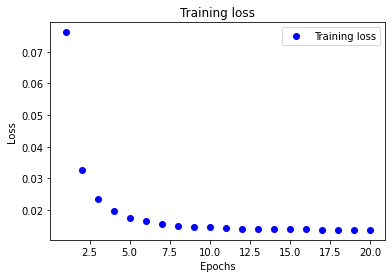

In [ ]:
loss = history.history['loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

What is training and validation accuracy?

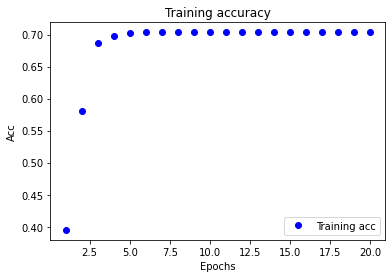

In [ ]:
plt.figure()
acc = history.history['accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

Okay lets make some predictions now on the newly trained model....

In [ ]:
predictions = model.predict(X_test)
Get_score(predictions, Y_test) # Try remember what the Spearman scores actually mean!

The Spearman's correlation coefficient is: 0.273
The Spearman's correlation coefficient is: 0.120


Saving your model

In [ ]:
os.chdir('/content/drive/My Drive/')
pickle.dump(rf, open('C3D_Model.sav', 'wb'))

## 3.3 Random Forest (0.324, 0.114)

In [ ]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, Y_train)

In [ ]:
predictions = rf.predict(X_test)

In [ ]:
Get_score(predictions, Y_test)

The Spearman's correlation coefficient is: 0.324
The Spearman's correlation coefficient is: 0.114


In [ ]:
os.chdir('/content/drive/My Drive/')
pickle.dump(rf, open('Rain_forest.sav', 'wb'))

## 3.4 Support Vector Regressor (0.265, 0.041)

In [ ]:
print(Y_train[1:2,0])

[0.787]


In [ ]:
regressor = BaggingRegressor(SVR(kernel = 'rbf'))
regressor.fit(X_train, Y_train[:,0])

In [ ]:
predictions = regressor.predict(X_test)

In [ ]:
Get_score(predictions, Y_test[:,0])

The Spearman's correlation coefficient is: 0.265


In [ ]:
regressor_long_term_memorability =  BaggingRegressor(SVR(kernel = 'rbf'))
regressor_long_term_memorability.fit(X_train, Y_train[:,1]);

In [ ]:
predictions_long_term = regressor_long_term_memorability.predict(X_test)

In [ ]:
Get_score(predictions_long_term, Y_test[:,1])

The Spearman's correlation coefficient is: 0.041


## 3.5 Gradient Boosting Regression (0.311, 0.110)

In [ ]:
model= GradientBoostingRegressor()
model.fit(X_train, Y_train[:,0])

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
predictions = model.predict(X_test)

In [ ]:
Get_score(predictions, Y_test[:,0])

The Spearman's correlation coefficient is: 0.311


In [ ]:
model= GradientBoostingRegressor()
model.fit(X_train, Y_train[:,1])
predictions = model.predict(X_test)
Get_score(predictions, Y_test[:,1])

The Spearman's correlation coefficient is: 0.110


## 3.6 Elastic Net (0.282, 0.118)

In [ ]:
# define model
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, Y_train)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.308912512342543, tolerance: 0.0031603040479166646
  positive)


MAE: -0.087
Config: {'alpha': 0.001, 'l1_ratio': 0.0}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.14746054834263, tolerance: 0.009935011935916671
  positive)


In [ ]:
ElasticNet_model = ElasticNet(alpha=0.001, l1_ratio=0.0)

In [ ]:
ElasticNet_model.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.308912512342543, tolerance: 0.0031603040479166646
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.14746054834263, tolerance: 0.009935011935916671
  positive)


ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.0,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
predictions = ElasticNet_model.predict(X_test)

In [ ]:
Get_score(predictions, Y_test)

The Spearman's correlation coefficient is: 0.282
The Spearman's correlation coefficient is: 0.118


# 4> Predicting video memorability using LBP

## 4.1 Loading LBP

In [ ]:
os.chdir('/content/drive/My Drive/CA684_Assignment')

# Read LBP files
def read_LBP(fname):
    """Scan vectors from file"""   
    if os.path.exists(fname):
      with open(fname) as f:
          for line in f:
              LBP =[float(item) for item in line.split()] # convert to float type, using default separator
      return LBP
    else:
      return np.zeros(122)

df_lbp = pd.DataFrame(columns=['video','LBP-0','LBP-56','LBP-112'])

# load the LBP
for i, video in enumerate(labels['video']):
    df_lbp.loc[i,'video'] = video   
    df_lbp.loc[i,'LBP-0'] = read_LBP('./Dev-set/LBP/' + (video.split('.')[0]) + '-0.txt')
    df_lbp.loc[i,'LBP-56'] = read_LBP('./Dev-set/LBP/' + (video.split('.')[0]) + '-56.txt')
    df_lbp.loc[i,'LBP-112'] = read_LBP('./Dev-set/LBP/' + (video.split('.')[0]) + '-112.txt')

df_lbp.head()

,video,LBP-0,LBP-56,LBP-112
0,video3.webm,"[0.01183208, 0.00234423, 0.00182726, 0.0013999...","[0.01051071, 0.00238281, 0.00180411, 0.0014699...","[0.01043451, 0.00247637, 0.00192178, 0.0014665..."
1,video4.webm,"[0.00966435, 0.00291811, 0.00219425, 0.0018682...","[0.01016445, 0.00291377, 0.00232832, 0.0020452...","[0.00991127, 0.00292679, 0.00233845, 0.0020862..."
2,video6.webm,"[0.01084008, 0.00189525, 0.00154128, 0.0009606...","[0.00749759, 0.00117043, 0.00096595, 0.0007257...","[0.00782986, 0.00120563, 0.00085166, 0.0006939..."
3,video8.webm,"[0.01163436, 0.00431472, 0.00321277, 0.0019121...","[0.01338397, 0.00459394, 0.00335214, 0.0026601...","[0.01097222, 0.00419367, 0.0028178, 0.00211709..."
4,video10.webm,"[0.02525029, 0.00485774, 0.00489198, 0.0038623...","[0.02373216, 0.00531973, 0.00533999, 0.0046180...","[0.02204427, 0.00510851, 0.00511767, 0.0041420..."


In [ ]:
os.chdir('/content/drive/My Drive/')
df_lbp.to_pickle("LBP_file.pkl")

In [ ]:
os.chdir('/content/drive/My Drive/CA684 - Machine Learning Assignment')
df_lbp = pd.read_pickle("LBP_file.pkl")
print(df_lbp)

               video  ...                                            LBP-112
0        video3.webm  ...  [0.01043451, 0.00247637, 0.00192178, 0.0014665...
1        video4.webm  ...  [0.00991127, 0.00292679, 0.00233845, 0.0020862...
2        video6.webm  ...  [0.00782986, 0.00120563, 0.00085166, 0.0006939...
3        video8.webm  ...  [0.01097222, 0.00419367, 0.0028178, 0.00211709...
4       video10.webm  ...  [0.02204427, 0.00510851, 0.00511767, 0.0041420...
...              ...  ...                                                ...
5995  video7488.webm  ...  [0.01651235, 0.0036738, 0.00279562, 0.00200762...
5996  video7489.webm  ...  [0.03702064, 0.00227286, 0.00241802, 0.0025082...
5997  video7491.webm  ...  [0.02289207, 0.00598573, 0.00546055, 0.0042144...
5998  video7492.webm  ...  [0.01113329, 0.00202691, 0.00201678, 0.0017365...
5999  video7493.webm  ...  [0.01129292, 0.00211179, 0.0017853, 0.00150222...

[6000 rows x 4 columns]


In [ ]:
len(df_lbp.loc[0,'LBP-56'])

122

In [ ]:
# calculating max length
max_len = 366

In [ ]:
X_seq = np.zeros((len(df_lbp['LBP-112']),max_len))
count = 0
for i in range(len(df_lbp['LBP-112'])):
    n = 366
    if n==0:
        print(i)
    elif len(df_lbp.loc[i,'LBP-112'] + df_lbp.loc[i,'LBP-56'] + df_lbp.loc[i,'LBP-0']) == 366:
        X_seq[i,-n:] = df_lbp.loc[i,'LBP-0'] + df_lbp.loc[i,'LBP-56'] + df_lbp.loc[i,'LBP-112']
    else:
      count = count + 1
print(count)
X_seq.shape

15


(6000, 366)

In [ ]:
X_train, X_test, Y_train, Y_test = Split_data(X_seq)

## 4.2 Random Forest (0.328, 0.064)

In [ ]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
predictions = rf.predict(X_test)

In [ ]:
Get_score(predictions, Y_test)

The Spearman's correlation coefficient is: 0.328
The Spearman's correlation coefficient is: 0.064


## 4.3 Support Vector Regressor (0.249, 0.085)

In [ ]:
regressor = BaggingRegressor(SVR(kernel = 'rbf'))
regressor.fit(X_train, Y_train[:,0])
predictions = regressor.predict(X_test)
Get_score(predictions, Y_test[:,0])

The Spearman's correlation coefficient is: 0.249


In [ ]:
regressor_long_term_memorability =  BaggingRegressor(SVR(kernel = 'rbf'))
regressor_long_term_memorability.fit(X_train, Y_train[:,1])
predictions_long_term = regressor_long_term_memorability.predict(X_test)
Get_score(predictions_long_term, Y_test[:,1])

The Spearman's correlation coefficient is: 0.085


## 4.4 Elastic Net (0.232, 0.077)

In [ ]:
ElasticNet_model = ElasticNet(alpha=0.001, l1_ratio=0.0)
ElasticNet_model.fit(X_train, Y_train)
predictions = ElasticNet_model.predict(X_test)
Get_score(predictions, Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.39708553954809, tolerance: 0.0031603040479166646
  positive)


The Spearman's correlation coefficient is: 0.232
The Spearman's correlation coefficient is: 0.077


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.38808776517216, tolerance: 0.009935011935916671
  positive)


## 4.5 Gradient Boosting Regression (0.298, 0.061)

In [ ]:
model= GradientBoostingRegressor()
model.fit(X_train, Y_train[:,0])
predictions = model.predict(X_test)
Get_score(predictions, Y_test[:,0])

The Spearman's correlation coefficient is: 0.298


In [ ]:
model= GradientBoostingRegressor()
model.fit(X_train, Y_train[:,1])
predictions = model.predict(X_test)
Get_score(predictions, Y_test[:,1])

The Spearman's correlation coefficient is: 0.061


# 5> Predicting video memorability using Aesthetic features

## 5.1 Loading Aesthetic features

In [ ]:
os.chdir('/content/drive/My Drive/CA684 - Machine Learning Assignment/dev-set_aesthetic-features/features/aesthetic_visual_features')

# Read Aesthetic mean and median feature files
def read_aesthetic_features(fname):
    """Scan vectors from file""" 
    if os.path.exists(fname):
      with open(fname) as f:
          for line in f:
              aes =[float(item) for item in line.split(',')] # convert to float type, using default separator
      return aes
    else:
      return np.zeros(109)

In [ ]:
df_aes = pd.DataFrame(columns=['video','AES-mean','AES-median'])

pbar = pyprind.ProgBar(len(labels['video']), title='Loading Aesthetic files')

# load the Aesthetic files
for i, video in enumerate(labels['video']):
    df_aes.loc[i,'video'] = video   
    df_aes.loc[i,'AES-mean'] = read_aesthetic_features('./aesthetic_feat_dev-set_mean/' + (video.split('.')[0]) + '.txt')
    df_aes.loc[i,'AES-median'] = read_aesthetic_features('./aesthetic_feat_dev-set_median/' + (video.split('.')[0]) + '.txt')
    pbar.update()

In [ ]:
os.chdir('/content/drive/My Drive/')
df_aes.to_pickle("AES_file.pkl")

In [ ]:
os.chdir('/content/drive/My Drive/CA684 - Machine Learning Assignment')
df_aes = pd.read_pickle("AES_file.pkl")
print(df_aes)

               video  ...                                         AES-median
0        video3.webm  ...  [0.180874, 0.715626, 0.19893, 0.610453, 0.1216...
1        video4.webm  ...  [0.146076, 0.55007, 0.460729, 0.424397, 0.3418...
2        video6.webm  ...  [0.063898, 0.827439, 0.211925, 0.720297, 0.129...
3        video8.webm  ...  [0.380539, 0.134683, 0.746891, 0.171604, 0.697...
4       video10.webm  ...  [0.427258, 0.381448, 0.582746, 0.409475, 0.489...
...              ...  ...                                                ...
5995  video7488.webm  ...  [0.413464, 0.195451, 0.71372, 0.282848, 0.6534...
5996  video7489.webm  ...  [0.264377, 0.192016, 0.448979, 0.164919, 0.412...
5997  video7491.webm  ...  [0.177078, 0.221348, 0.67387, 0.180848, 0.6131...
5998  video7492.webm  ...  [0.113838, 0.585274, 0.496719, 0.474999, 0.352...
5999  video7493.webm  ...  [0.554715, 0.132732, 0.691821, 0.209476, 0.646...

[6000 rows x 3 columns]


In [ ]:
max_len = 109
X_seq = define_x_seq(df_aes,max_len,'AES-mean', len(df_aes.loc[0,'AES-mean']))
X_seq.shape

(6000, 109)

In [ ]:
X_train, X_test, Y_train, Y_test = Split_data(X_seq)

## 5.2 Random Forest (0.324, 0.134)

In [ ]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
predictions = rf.predict(X_test)
Get_score(predictions, Y_test)

The Spearman's correlation coefficient is: 0.324
The Spearman's correlation coefficient is: 0.134


## 5.3 Support Vector Regressor (0.197, 0.097)

In [ ]:
regressor = BaggingRegressor(SVR(kernel = 'rbf'))
regressor.fit(X_train, Y_train[:,0])
predictions = regressor.predict(X_test)
Get_score(predictions, Y_test[:,0])

The Spearman's correlation coefficient is: 0.197


In [ ]:
regressor_long_term_memorability =  BaggingRegressor(SVR(kernel = 'rbf'))
regressor_long_term_memorability.fit(X_train, Y_train[:,1])
predictions_long_term = regressor_long_term_memorability.predict(X_test)
Get_score(predictions_long_term, Y_test[:,1])

The Spearman's correlation coefficient is: 0.097


## 5.4 Elastic Net (0.270, 0.118)

In [ ]:
ElasticNet_model = ElasticNet(alpha=0.001, l1_ratio=0.0)
ElasticNet_model.fit(X_train, Y_train)
predictions = ElasticNet_model.predict(X_test)
Get_score(predictions, Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.242866206270572, tolerance: 0.0031603040479166646
  positive)


The Spearman's correlation coefficient is: 0.270
The Spearman's correlation coefficient is: 0.118


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.82902136217619, tolerance: 0.009935011935916671
  positive)


## 5.5 Gradient Boosting Regressor (0.284, 0.110)

In [ ]:
model= GradientBoostingRegressor()
model.fit(X_train, Y_train[:,0])
predictions = model.predict(X_test)
Get_score(predictions, Y_test[:,0])

The Spearman's correlation coefficient is: 0.284


In [ ]:
model= GradientBoostingRegressor()
model.fit(X_train, Y_train[:,1])
predictions = model.predict(X_test)
Get_score(predictions, Y_test[:,1])

The Spearman's correlation coefficient is: 0.110


# 6> Apply LBP and C3D on Elastic Net, Random Forest and Gradient Boosting Regressor

## 6.1 Loading Data

In [ ]:
max_len = 467
len(pickle_df_c3d)
X_seq = np.zeros((len(df_lbp['LBP-112']),max_len))
count = 0
for i in range(len(df_lbp['LBP-112'])):
    n = 467
    if n==0:
        print(i)
    elif len(df_lbp.loc[i,'LBP-0'] + df_lbp.loc[i,'LBP-56'] + df_lbp.loc[i,'LBP-112']) == 366:
        X_seq[i,-n:] = df_lbp.loc[i,'LBP-0'] + df_lbp.loc[i,'LBP-56'] + df_lbp.loc[i,'LBP-112'] + pickle_df_c3d.loc[i,'C3D']
    else:
      count = count + 1
print(count)
X_seq.shape

15


(6000, 467)

In [ ]:
X_train, X_test, Y_train, Y_test =Split_data(X_seq)

## 6.2 Elastic Net (0.293, 0.124)

In [ ]:
ElasticNet_model = ElasticNet(alpha=0.001, l1_ratio=0.0)
ElasticNet_model.fit(X_train, Y_train)
predictions = ElasticNet_model.predict(X_test)
Get_score(predictions, Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.257270377322309, tolerance: 0.0031603040479166646
  positive)


The Spearman's correlation coefficient is: 0.293
The Spearman's correlation coefficient is: 0.124


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.09832705440102, tolerance: 0.009935011935916671
  positive)


## 6.3 Random Forest (0.337, 0.132)

In [ ]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, Y_train)
predictions = rf.predict(X_test)
Get_score(predictions, Y_test)

The Spearman's correlation coefficient is: 0.337
The Spearman's correlation coefficient is: 0.132


## 6.4 Gradient Boosting Regression (0.330, 0.096)

In [ ]:
model= GradientBoostingRegressor()
model.fit(X_train, Y_train[:,0])
predictions = model.predict(X_test)
Get_score(predictions, Y_test[:,0])

The Spearman's correlation coefficient is: 0.330


In [ ]:
model.fit(X_train, Y_train[:,1])
predictions = model.predict(X_test)
Get_score(predictions, Y_test[:,1])

The Spearman's correlation coefficient is: 0.096


# 7> Load Ground-truth, LBP, C3D and Aesthetic features from Test-set.  

## 7.1 Load Ground truth

In [ ]:
os.chdir('/content/drive/My Drive/CA684_Assignment')
label_test_path = './Test-set/Ground-truth_test/'
labels_test=pd.read_csv(label_test_path+'ground_truth_template.csv')
labels_test.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10
2,7496,NaN,32,NaN,13
3,7497,NaN,33,NaN,10
4,7498,NaN,33,NaN,10


## 7.2 Short-term memorability model

### 7.2.1 Load LBP

In [ ]:
os.chdir('/content/drive/My Drive/CA684_Assignment')

# Read LBP files
def read_LBP(fname):
    """Scan vectors from file"""   
    if os.path.exists(fname):
      with open(fname) as f:
          for line in f:
              LBP =[float(item) for item in line.split()] # convert to float type, using default separator
      return LBP
    else:
      return np.zeros(122)

pbar = pyprind.ProgBar(len(labels_test['video']), title='Loading LBP files')

df_lbp_test = pd.DataFrame(columns=['video','LBP-0','LBP-56','LBP-112'])

# load the LBP
for i, video in enumerate(labels_test['video']):
    df_lbp_test.loc[i,'video'] = video   
    df_lbp_test.loc[i,'LBP-0'] = read_LBP('./Test-set/LBP_test/' + 'video' + str(video) + '-0.txt')
    df_lbp_test.loc[i,'LBP-56'] = read_LBP('./Test-set/LBP_test/' + 'video' + str(video) + '-56.txt')
    df_lbp_test.loc[i,'LBP-112'] = read_LBP('./Test-set/LBP_test/' + 'video' + str(video) + '-112.txt')
    pbar.update()

print(df_lbp_test.head())

os.chdir('/content/drive/My Drive/')
df_lbp_test.to_pickle("LBP_test_file.pkl")

Loading LBP files
0% [##############################] 100% | ETA: 00:00:00

  video  ...                                            LBP-112
0  7494  ...  [0.02417197, 0.00418789, 0.00467159, 0.0043050...
1  7495  ...  [0.01960311, 0.00339506, 0.00394001, 0.0038580...
2  7496  ...  [0.00498553, 0.00084443, 0.00075231, 0.0005550...
3  7497  ...  [0.00843509, 0.00161748, 0.00147762, 0.0012842...
4  7498  ...  [0.01391638, 0.00212577, 0.00200183, 0.0017192...

[5 rows x 4 columns]



Total time elapsed: 00:25:05


### 7.2.2 Load C3D

In [ ]:
#Change the directory
os.chdir('/content/drive/My Drive/CA684_Assignment')

# load C3D
def read_C3D(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()] # convert to float type, using default separator
    return C3D

df_c3d_test = pd.DataFrame(columns=['video','C3D'])

pbar = pyprind.ProgBar(len(labels_test['video']), title='Loading C3D files')

# load the C3D
for i, video in enumerate(labels_test['video']):
    File_name = 'video' + str(video) + '.txt'
    c3d_path = './Test-set/C3D_test/' + File_name
    df_c3d_test.loc[i,'video'] = video
    df_c3d_test.loc[i,'C3D'] = read_C3D(c3d_path)
    pbar.update()

print(df_c3d_test.head())

os.chdir('/content/drive/My Drive/')
df_c3d_test.to_pickle("C3D_test_file.pkl")

Loading C3D files
0% [##############################] 100% | ETA: 00:00:00

  video                                                C3D
0  7494  [0.00013576, 0.0002133, 0.00124759, 1.149e-05,...
1  7495  [0.00012659, 2.377e-05, 0.04950115, 2.418e-05,...
2  7496  [0.48898152, 0.00058536, 2.454e-05, 0.00016031...
3  7497  [0.24925078, 0.00101763, 8.02e-06, 1.92e-05, 2...
4  7498  [0.00989415, 3.413e-05, 0.00261261, 2.1e-06, 1...



Total time elapsed: 00:06:58


### 7.2.3 Create X_train and Y_train from 6000 dataset for training purpose

In [ ]:
max_len = 467
len(pickle_df_c3d)
X_train = np.zeros((len(df_lbp['LBP-112']),max_len))
count = 0
invalid_LBP_File = []
for i in range(len(df_lbp['LBP-112'])):
    n = 467
    if n==0:
        print(i)
    elif len(df_lbp.loc[i,'LBP-0'] + df_lbp.loc[i,'LBP-56'] + df_lbp.loc[i,'LBP-112']) == 366:
        X_train[i,-n:] = df_lbp.loc[i,'LBP-0'] + df_lbp.loc[i,'LBP-56'] + df_lbp.loc[i,'LBP-112'] + pickle_df_c3d.loc[i,'C3D']
    else:
      count = count + 1
print(count)
X_train.shape

15


(6000, 467)

In [ ]:
Y_train = labels[['short-term_memorability','long-term_memorability']].values # targets

In [ ]:
Y_train.shape

(6000, 2)

### 7.2.4 Create X_test on 2000 dataset for evaluation purpose

In [ ]:
max_len = 467
X_test = np.zeros((len(df_lbp_test['LBP-112']),max_len))
count = 0
for i in range(len(df_lbp_test['LBP-112'])):
    n = 467
    if n==0:
        print(i)
    elif len(df_lbp_test.loc[i,'LBP-0'] + df_lbp_test.loc[i,'LBP-56'] + df_lbp_test.loc[i,'LBP-112']) == 366:
        X_test[i,-n:] = df_lbp_test.loc[i,'LBP-0'] + df_lbp_test.loc[i,'LBP-56'] + df_lbp_test.loc[i,'LBP-112'] + df_c3d_test.loc[i,'C3D']
    else:
      count = count + 1
print(count)
X_test.shape

4


(2000, 467)

### 7.2.5 Random Forest

In [ ]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, Y_train)
predictions = rf.predict(X_test)

In [ ]:
os.chdir('/content/drive/My Drive/')
pickle.dump(rf, open('Random_Forest_text_Short_term_Model.sav', 'wb'))

In [ ]:
predictions[0,0]

0.8480917499999994

In [ ]:
for i, video in enumerate(labels_test['video']):
  labels_test.loc[i,'short-term_memorability'] = predictions[i,0]

In [ ]:
labels_test.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,0.848092,33,NaN,12
1,7495,0.816057,34,NaN,10
2,7496,0.859052,32,NaN,13
3,7497,0.889942,33,NaN,10
4,7498,0.844994,33,NaN,10


In [ ]:
os.chdir('/content/drive/My Drive/')
labels_test.to_pickle("Short-term_Scores.pkl")

## 7.3 Long-term memorability model

### 7.3.1 Load Aesthetic features

In [ ]:
#Change the directory
os.chdir('/content/drive/My Drive/CA684_Assignment')

# Read Aesthetic mean feature files
def read_aesthetic_features(fname):
    """Scan vectors from file""" 
    if os.path.exists(fname):
      with open(fname) as f:
          for line in f:
              aes =[float(item) for item in line.split(',')] # convert to float type, using default separator
      return aes
    else:
      return np.zeros(109)

df_test_aes = pd.DataFrame(columns=['video','AES-mean'])

pbar = pyprind.ProgBar(len(labels_test['video']), title='Loading Aesthetic files')

# load the Aesthetic files
for i, video in enumerate(labels_test['video']):
    df_test_aes.loc[i,'video'] = video   
    df_test_aes.loc[i,'AES-mean'] = read_aesthetic_features('./Test-set/aesthetic_vis_features_test/mean/' + 'video' + str(video) + '.txt')
    pbar.update()

print(df_test_aes.head())

os.chdir('/content/drive/My Drive/')
df_test_aes.to_pickle("Aestheic_test_file.pkl")

Loading Aesthetic files
0% [##############################] 100% | ETA: 00:00:00

  video                                           AES-mean
0  7494  [0.15188, 0.435622, 0.385821, 0.324642, 0.3163...
1  7495  [0.346129, 0.39686, 0.518731, 0.417674, 0.4222...
2  7496  [0.126344, 0.225354, 0.479295, 0.172265, 0.432...
3  7497  [0.217836, 0.338128, 0.633791, 0.245464, 0.529...
4  7498  [0.436468, 0.292819, 0.4736, 0.270421, 0.40387...



Total time elapsed: 00:08:44


### 7.3.2 Create X_train and Y_train on 6000 dataset for training purpose

In [ ]:
max_len = 109
X_train = define_x_seq(df_aes,max_len,'AES-mean', len(df_aes.loc[0,'AES-mean']))
X_train.shape

(6000, 109)

In [ ]:
Y_train = labels[['short-term_memorability','long-term_memorability']].values # targets

### 7.3.3 Create X_test on 2000 dataset for evaluation purpose

In [ ]:
max_len = 109
X_test = define_x_seq(df_test_aes,max_len,'AES-mean', len(df_test_aes.loc[0,'AES-mean']))
X_test.shape

(2000, 109)

### 7.3.4 Random Forest

In [ ]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, Y_train)
predictions = rf.predict(X_test)
os.chdir('/content/drive/My Drive/')
pickle.dump(rf, open('Random_Forest_text_long_term_Model.sav', 'wb'))

In [ ]:
predictions[4,:]

array([0.831126, 0.773691])

In [ ]:
for i, video in enumerate(labels_test['video']):
  labels_test.loc[i,'long-term_memorability'] = predictions[i,1]

In [ ]:
labels_test.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,0.848092,33,0.736455,12
1,7495,0.816057,34,0.765673,10
2,7496,0.859052,32,0.786938,13
3,7497,0.889942,33,0.785356,10
4,7498,0.844994,33,0.773691,10


In [ ]:
os.chdir('/content/drive/My Drive/')
labels_test.to_csv("Final_prediction_20210205_Sanchit_Akhauri.csv")

## 7.4 Summary of Spearman's correlation coefficient of all the models

In [ ]:
df=pd.DataFrame({"Random Forest":['0.314','0.324','0.328','0.324','0.337'],
                 "Gradient Boosting Regressor":['0.296','0.311','0.298','0.284','0.330'],
                 "Elastic Net":['0.271','0.282','0.232','0.270','0.293'],
                 "Support Vector Regressor":['0.309','0.265','0.249','0.197','-'],
                 "Dense Layer":['-0.052','0.273','-','-','-']})
df.index = ['HMP', 'C3D', 'LBP', 'Aethetic','LBP + C3D']
df.head()

,Random Forest,Gradient Boosting Regressor,Elastic Net,Support Vector Regressor,Dense Layer
HMP,0.314,0.296,0.271,0.309,-0.052
C3D,0.324,0.311,0.282,0.265,0.273
LBP,0.328,0.298,0.232,0.249,-
Aethetic,0.324,0.284,0.270,0.197,-
LBP + C3D,0.337,0.330,0.293,-,-


In [ ]:
df=pd.DataFrame({"Random Forest":['0.080','0.114','0.064','0.134','0.132'],
                 "Gradient Boosting Regressor":['0.058','0.110','0.061','0.110','0.096'],
                 "Elastic Net":['0.112','0.118','0.077','0.118','0.124'],
                 "Support Vector Regressor":['0.091','0.041','0.085','0.097','-'],
                 "Dense Layer":['0.013','0.120','-','-','-']})
df.index = ['HMP', 'C3D', 'LBP', 'Aethetic','LBP + C3D']
df.head()

,Random Forest,Gradient Boosting Regressor,Elastic Net,Support Vector Regressor,Dense Layer
HMP,0.080,0.058,0.112,0.091,0.013
C3D,0.114,0.110,0.118,0.041,0.120
LBP,0.064,0.061,0.077,0.085,-
Aethetic,0.134,0.110,0.118,0.097,-
LBP + C3D,0.132,0.096,0.124,-,-
